# Develop and train a Conditional GAN on MNIST dataset

## Import required modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.utils.data as data_utils
import torch.nn.init as weight_init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [2]:
file_train = '../Hw2/Data/train-images.idx3-ubyte'
arr_train = idx2numpy.convert_from_file(file_train)

In [3]:
file_train_lbl = "../Hw2/Data/train-labels.idx1-ubyte"
arr_train_lbl = idx2numpy.convert_from_file(file_train_lbl)

In [4]:
# SLicing few indices for equal batch groups
arr_train = arr_train[:-96,:,:]
arr_train_lbl = arr_train_lbl[:-96]

In [5]:
# Convert to float32 and long respectively
train_data_arr = arr_train.astype('float32')
arr_train_lbl = arr_train_lbl.astype('long')

In [6]:
# Normalizing between 0, 1
train_data_arr = train_data_arr/255.

In [7]:
# Reshaping it to match the input shape
tr_shape = train_data_arr.shape
train_data_arr = train_data_arr.reshape(tr_shape[0],1,tr_shape[1], tr_shape[2])

In [8]:
# Creating torch tensors
train_data_arr = torch.from_numpy(train_data_arr)
arr_train_lbl = torch.from_numpy(arr_train_lbl)

In [9]:
train = data_utils.TensorDataset(train_data_arr, arr_train_lbl)

In [10]:
# Making a DataLoader from train data
train_loader = DataLoader(train, batch_size=128, shuffle=True)

## Build cGAN model

### Intialize weights using Normal distribution

In [13]:
# Weight initialization
# Conv layers get the weight vectors from the Normal dist- mu=0, std=0.02
def weights(vec):
    layernames = vec.__class__.__name__
    if layernames.find('Conv') !=-1:
        nn.init.normal_(vec.weight.data, 0.0, 0.02)
    elif layernames.find('BatchNorm') != -1:
        nn.init.normal_(vec.weight.data, 1.0,0.02)
        nn.init.constant_(vec.bias.data, 0)

### Generator model

In [14]:
# Generator class
class GAN_generator(nn.Module): 
    def __init__(self):
        super(GAN_generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(74, 64, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=1, padding=0, bias= False),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, bias= False),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True))
    def forward(self,x):
        return self.main(x)

### Discriminator model

In [15]:
# Discriminator class
class GAN_discriminator(nn.Module):
    def __init__(self):
        super(GAN_discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.main(x)

### Loss, Optimizers and model initialization

In [16]:
# Model initialization
model_discriminator = GAN_discriminator().to(device)
model_generator = GAN_generator().to(device)
# Initializing the weight parameters 
model_discriminator.apply(weights)
model_generator.apply(weights)
# Binary cross entropy for loss and Adam for optimizer
loss_function = nn.BCEWithLogitsLoss()
optim_g = Adam(model_generator.parameters(), lr=0.0002, betas = (0.5,0.999))
optim_d = Adam(model_discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

## Step-1: Update Discriminator

In [17]:
# Helper function to get Cm matrix
def C_m(label):
    # Create a Zeros tensor and update only the (28x28) tensor corresponding to the label with 1
    c_vec = torch.zeros((128,10,28,28))
    for i in range(len(label)):
        c_vec[i,label[i]] = 1
    return c_vec

In [18]:
# Training model
num_epochs = 30
avg_loss_d = []
avg_loss_g = []
flag = 0
for epoch in range(num_epochs):
    train_loss_d = 0
    train_loss_g = 0
    for (img, att) in train_loader:
        # Training discriminator on real images
        optim_d.zero_grad()
        # Creating a Cm matrix representing classes of the images 
        c_vec = C_m(att)
        # Concatinating this vector with the real image so the real_ img is of shape (11,28,28)
        real_img = torch.cat([img,c_vec], dim=1)
        # Getting output from the discriminator model
        output_d_real = model_discriminator(real_img.float().to(device)).view(-1)
        # Creating a real label vector to calulate losses on - real labels are marked 1
        real_lbl = torch.ones((128,), device=device)
        loss_real_d = loss_function(output_d_real, real_lbl)
        
        # Training discriminator on fake images
        # Creating a random noise vector
        noise_vec = torch.randn(128, 64)
        # One hot encoding the class labels
        class_vec = F.one_hot(att.long(), 10)
        # Concatinating with the class vector to get a 74 channel (z_d+10) (1,1) images for generator
        noise_input = torch.cat([noise_vec, class_vec],dim=1).reshape((128,74,1,1))
        noise_input = noise_input.to(device)
        # Generating the images from the noise and class labels using generator
        fake_img = model_generator(noise_input)
        # Passing these fake images generated from generator, concatinated with Cm vector to a discriminator
        output_d_fake = model_discriminator(torch.cat([fake_img.detach(),c_vec.to(device)], dim=1)).view(-1)
        # Getting loss on the fake images using fake labels, fake labels are marked using a 0
        fake_lbl = torch.zeros((128,), device=device)
        loss_fake_d = loss_function(output_d_fake, fake_lbl)
        # We add loss on fake and real images and use this to optimise discriminator
        total_loss_d = loss_real_d + loss_fake_d
        total_loss_d.backward()
        optim_d.step()
        
        # Training generator 
        optim_g.zero_grad()
        # Fake images are generated in the earlier stage so we use the same fake image but pass it to the updated
        # discriminator to optimise the generator
        output_g_fake = model_discriminator(torch.cat([fake_img,c_vec.to(device)], dim=1)).view(-1)
        # We use the discriminator output and real labels to calculate loss for generator
        # Since generator is trying to generate real images
        loss_g = loss_function(output_g_fake, real_lbl)
        loss_g.backward()
        optim_g.step()
        
        train_loss_d = train_loss_d + total_loss_d
        train_loss_g = train_loss_g + loss_g
    if flag==0:
        print('Saved first epoch results.')
        with torch.no_grad():
            save_noise = noise_input[0].unsqueeze(0)
            save_log_fakeimg = model_generator(save_noise).detach().cpu()
            save_log_org_img = img[0]
            save_log_label = att[0]
            flag =1
    # Saving the loss values
    avg_loss_d.append(train_loss_d.cpu().detach().item())
    avg_loss_g.append(train_loss_g.cpu().detach().item())

Saved first epoch results.


In [32]:
save_log_fakeimg.shape

torch.Size([1, 1, 28, 28])

In [19]:
# Divide by batch_size
avg_loss_d = np.array(avg_loss_d)/128

In [21]:
avg_loss_g = np.array(avg_loss_g)/128

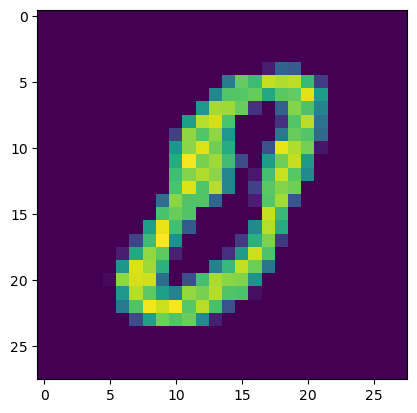

In [23]:
plt.imshow(fake_img[3].cpu().detach().permute(1,2,0))

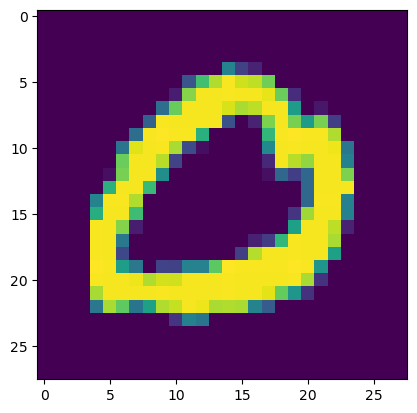

In [24]:
plt.imshow(img[3].cpu().detach().permute(1,2,0))

# Deliverables:

-> The network is trained for 30 epochs but the loss of the models were not converging

-> The generator was able to quite accurately predict almost all of the digits(shown in the sections later)

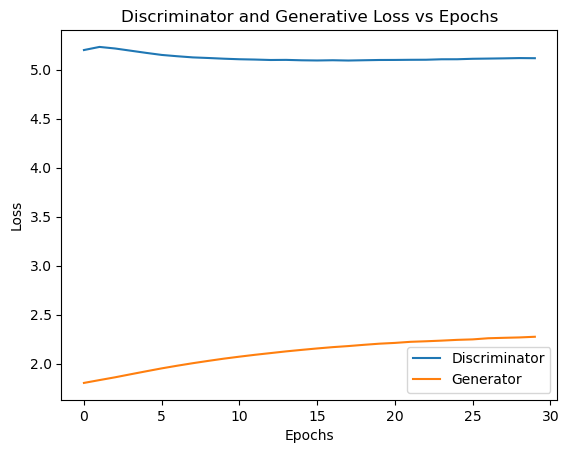

In [22]:
# PLotting losses of the models
plt.plot(np.arange(num_epochs), avg_loss_d, label='Discriminator')
plt.plot(np.arange(num_epochs), avg_loss_g, label='Generator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generative Loss vs Epochs')
plt.legend()
plt.show()

### Images of first and last epoch

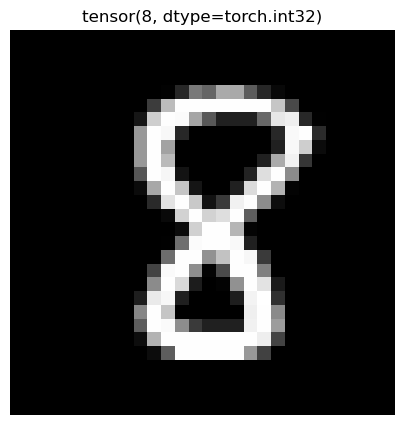

In [30]:
# Original image
plt.figure(figsize=(5,5))
plt.imshow(save_log_org_img.detach().cpu().permute(1,2,0), cmap='gray')
plt.title(save_log_label)
plt.axis('off')
plt.show()

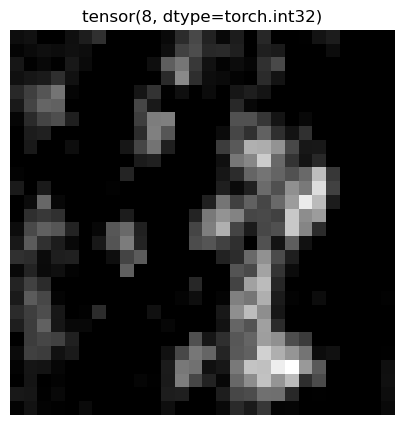

In [33]:
# Epoch 1 output
plt.figure(figsize=(5,5))
plt.imshow(save_log_fakeimg[0].permute(1,2,0), cmap='gray')
plt.title(save_log_label)
plt.axis('off')
plt.show()

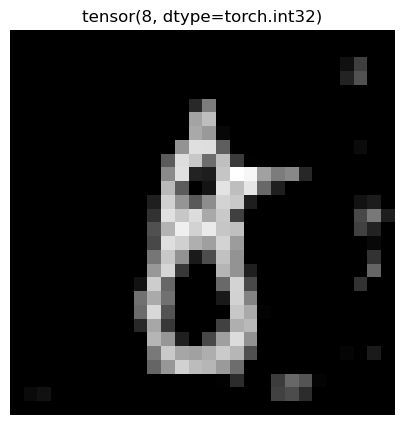

In [38]:
# Epoch 15 output
with torch.no_grad():
    train_full_img = model_generator(save_noise).detach().cpu()[0].permute(1,2,0)
plt.figure(figsize=(5,5))
plt.imshow(train_full_img, cmap='gray')
plt.title(save_log_label)
plt.axis('off')
plt.show()

### Samples of real and fake images for comparison

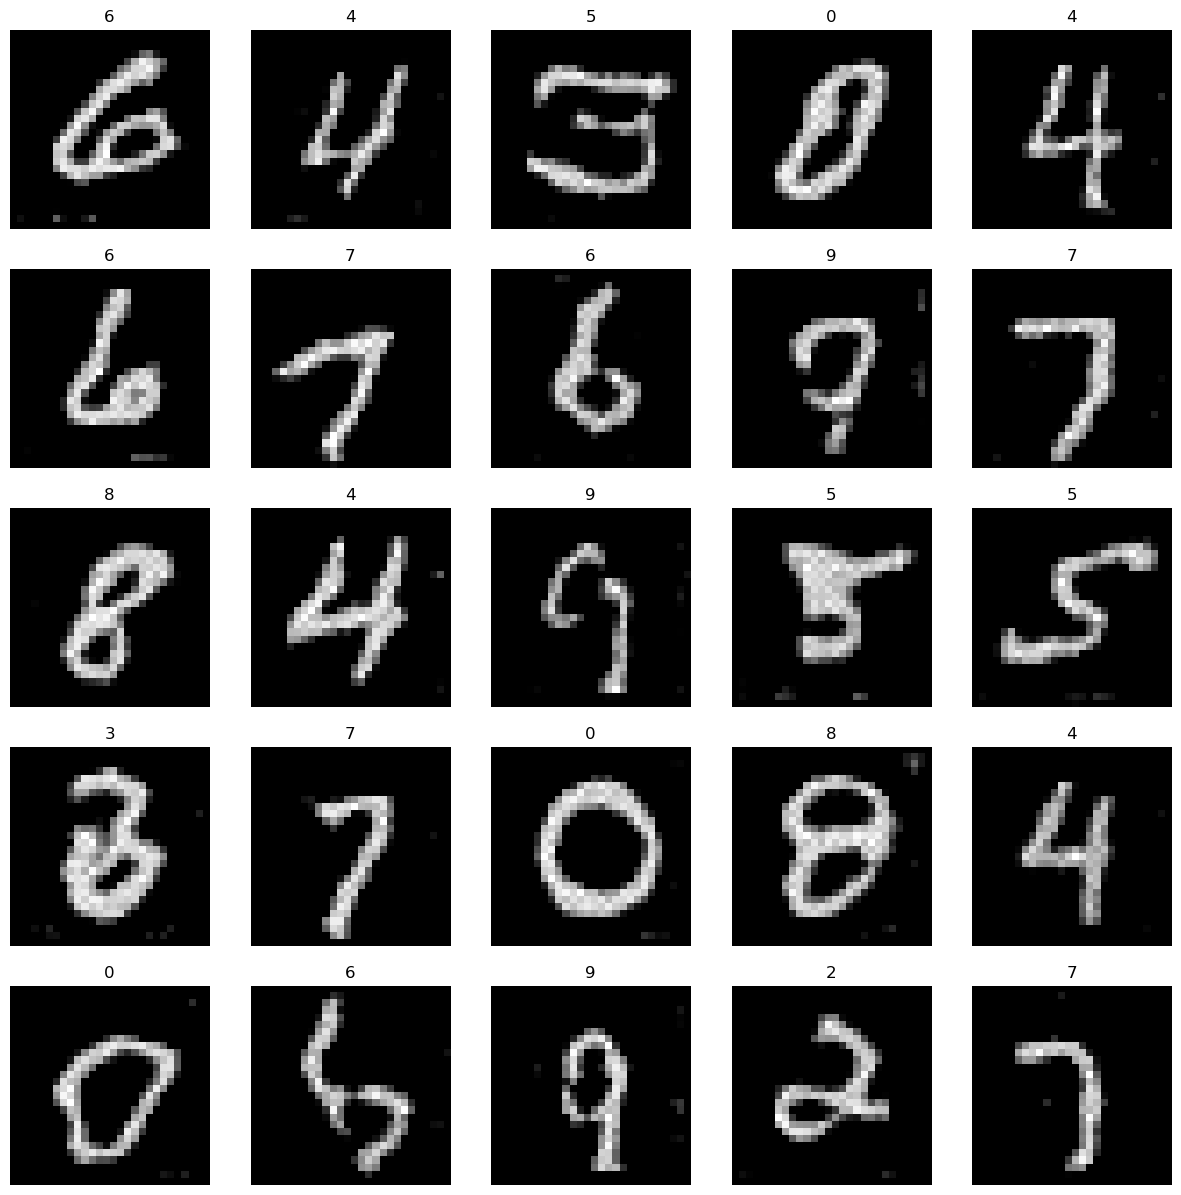

In [39]:
att = att.numpy()
figure, axis = plt.subplots(5, 5, figsize =(15,15))

k = 0
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(fake_img[k].cpu().detach().permute(1,2,0), cmap='gray')
        axis[i,j].set(title=att[k])
        axis[i,j].axis('off')
        k+=1
plt.show()

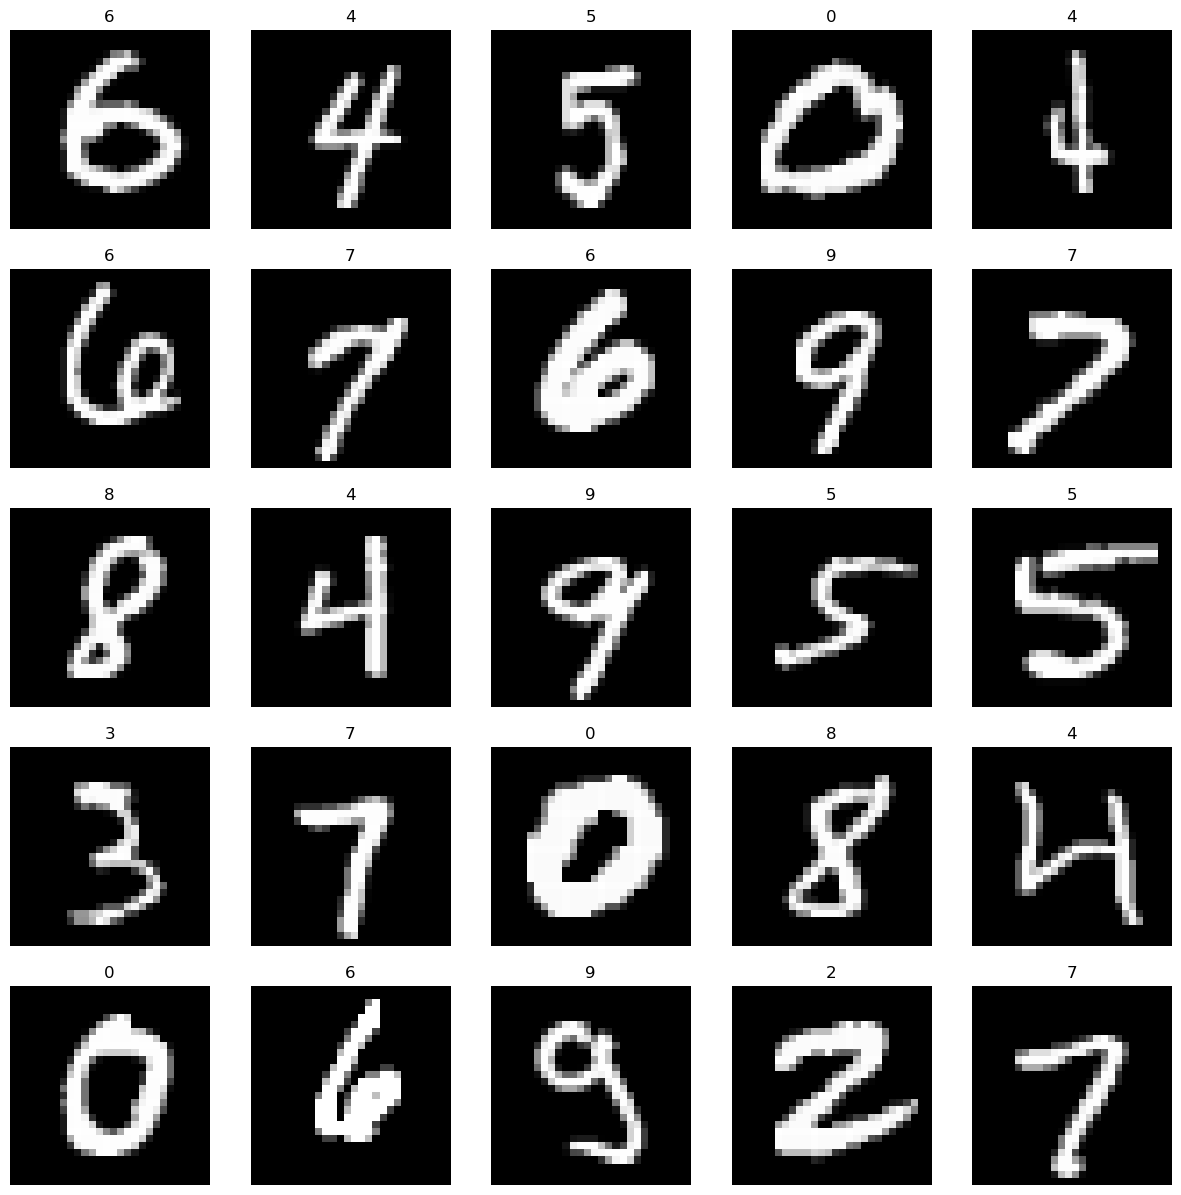

In [40]:
figure, axis = plt.subplots(5, 5, figsize =(15,15))

k = 0
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(img[k].cpu().detach().permute(1,2,0), cmap='gray')
        axis[i,j].set(title=att[k])
        axis[i,j].axis('off')
        k+=1
plt.show()

# End of Code